In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2024-02-03 14:41:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-03 14:41:52 (79.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [35]:
import tensorflow as tf
import tensorflow_datasets as tfds
from helper_functions import *

In [36]:
(train_data, test_data), info = tfds.load(name='food101',
                                          split=['train', 'validation'],
                                          as_supervised=True,
                                          with_info=True)

In [37]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [13]:
class_names = info.features['label'].names

In [7]:
import matplotlib.pyplot as plt


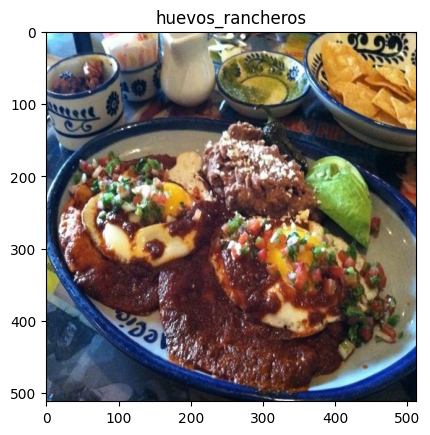

In [14]:
for image, label in train_data.take(1):
  plt.imshow(image)
  plt.title(class_names[label])

In [24]:
def preprocess_image(image,label, img_size=224):
  image = tf.image.resize(image, (img_size, img_size))
  image = tf.cast(image, dtype=tf.float32)
  return image, label

In [26]:
prep_img = preprocess_image(image, label)
prep_img[0].shape, prep_img[0].dtype

(TensorShape([224, 224, 3]), tf.float32)

In [38]:
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [39]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [40]:
backbone = tf.keras.applications.EfficientNetB0(include_top=False)
backbone.trainable = False
inputs = tf.keras.layers.Input(shape=(224,224,3))
x = backbone(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(101)(x)
outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32)(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 activation_2 (Activation)   (None, 101)               0         
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (

In [41]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [42]:
history_feature_extraction = model.fit(train_data,
                                       epochs=5,
                                       steps_per_epoch=len(train_data),
                                       validation_data=test_data,
                                       validation_steps=len(test_data))

Epoch 1/5
2368/2368 [==============================] - 224s 89ms/step - loss: 1.7194 - accuracy: 0.5831 - val_loss: 1.1377 - val_accuracy: 0.7006
Epoch 2/5
2368/2368 [==============================] - 209s 88ms/step - loss: 1.2017 - accuracy: 0.6873 - val_loss: 1.0449 - val_accuracy: 0.7164
Epoch 3/5
2368/2368 [==============================] - 197s 83ms/step - loss: 1.0564 - accuracy: 0.7224 - val_loss: 1.0048 - val_accuracy: 0.7283
Epoch 4/5
2368/2368 [==============================] - 236s 99ms/step - loss: 0.9612 - accuracy: 0.7479 - val_loss: 0.9831 - val_accuracy: 0.7320
Epoch 5/5
2368/2368 [==============================] - 214s 90ms/step - loss: 0.8911 - accuracy: 0.7654 - val_loss: 0.9799 - val_accuracy: 0.7310


In [44]:
result_feature_extration = model.evaluate(test_data)

790/790 [==============================] - 52s 65ms/step - loss: 0.9799 - accuracy: 0.7310


In [45]:
model.save("feature_extration_model")

In [76]:
loaded_model = tf.keras.models.load_model("feature_extration_model")

In [50]:
result_loaded_model = loaded_model.evaluate(test_data)

790/790 [==============================] - 59s 71ms/step - loss: 0.9799 - accuracy: 0.7310


In [53]:
result_feature_extration == result_loaded_model

True

In [70]:
# get loaded model summary
loaded_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 activation_2 (Activation)   (None, 101)               0         
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 1480341 

In [71]:
loaded_model.layers[1].trainable = True

In [72]:
# check loaded model for trainable layers
for layer in loaded_model.layers[1].layers:
  print(layer.name, layer.dtype_policy, layer.trainable)

input_5 <Policy "float32"> True
rescaling_4 <Policy "mixed_float16"> True
normalization_2 <Policy "mixed_float16"> True
rescaling_5 <Policy "mixed_float16"> True
stem_conv_pad <Policy "mixed_float16"> True
stem_conv <Policy "mixed_float16"> True
stem_bn <Policy "mixed_float16"> True
stem_activation <Policy "mixed_float16"> True
block1a_dwconv <Policy "mixed_float16"> True
block1a_bn <Policy "mixed_float16"> True
block1a_activation <Policy "mixed_float16"> True
block1a_se_squeeze <Policy "mixed_float16"> True
block1a_se_reshape <Policy "mixed_float16"> True
block1a_se_reduce <Policy "mixed_float16"> True
block1a_se_expand <Policy "mixed_float16"> True
block1a_se_excite <Policy "mixed_float16"> True
block1a_project_conv <Policy "mixed_float16"> True
block1a_project_bn <Policy "mixed_float16"> True
block2a_expand_conv <Policy "mixed_float16"> True
block2a_expand_bn <Policy "mixed_float16"> True
block2a_expand_activation <Policy "mixed_float16"> True
block2a_dwconv_pad <Policy "mixed_float

In [77]:
loaded_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                     metrics=['accuracy'])

In [78]:
# Create early stopping callback
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [79]:
history_all_layers = loaded_model.fit(train_data,
                                      epochs=100,
                                      validation_data=test_data,
                                      validation_steps=int(0.25 * len(test_data)),
                                      callbacks=[early_callback])

Epoch 1/100
2368/2368 [==============================] - 204s 81ms/step - loss: 0.9862 - accuracy: 0.7315 - val_loss: 0.8872 - val_accuracy: 0.7557
Epoch 2/100
2368/2368 [==============================] - 208s 86ms/step - loss: 0.6114 - accuracy: 0.8277 - val_loss: 0.9412 - val_accuracy: 0.7508
Epoch 3/100
2368/2368 [==============================] - 189s 78ms/step - loss: 0.3751 - accuracy: 0.8898 - val_loss: 1.0499 - val_accuracy: 0.7468
Epoch 4/100
2368/2368 [==============================] - 188s 78ms/step - loss: 0.2426 - accuracy: 0.9249 - val_loss: 1.1595 - val_accuracy: 0.7397
